In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

In [136]:

#get marmoset connectivity (paxinos atlas)

# load npz data - you should place your data.npz file in data directory
connmap_L_npz = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/results/diffparc/sub-betty/sub-betty_hemi-L_space-individual_label-ZI_from-MBMv212_connMap.npz'
connmap_R_npz = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/results/diffparc/sub-betty/sub-betty_hemi-R_space-individual_label-ZI_from-MBMv212_connMap.npz'


marm_conn_L = np.load(connmap_L_npz)['conn']
marm_conn_R = np.load(connmap_R_npz)['conn']


marm_affine=np.load(connmap_L_npz)['affine']

marm_mask_L=np.load(connmap_L_npz)['mask']
marm_mask_R=np.load(connmap_R_npz)['mask']

marm_nvox_L = marm_conn_L.shape[0]
marm_nvox_R = marm_conn_L.shape[0]

marm_conn = np.concatenate([marm_conn_L,marm_conn_R],axis=0)
marm_conn.shape


(648, 116)

In [88]:

marm_lut_tsv = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/resources/label-paxinos_dseg.tsv'
df_marm_lut = pd.read_csv(lut_tsv,sep='\t')
df_marm_lut

human_lut_tsv = 'https://raw.githubusercontent.com/akhanf/diffparc-smk/master/resources/label-hcpmmp180_dseg.tsv'
df_human_lut = pd.read_csv(human_lut_tsv,sep='\t',usecols=['name'])


homol_tsv = 'marm94T-gradients/notebooks/homologous_regions.tsv'
df_homol = pd.read_csv(homol_tsv,sep='\t')



In [89]:
df_human_lut

,name
0,V1
1,MST
2,V6
3,V2
4,V3
...,...
175,STSva
176,TE1m
177,PI
178,a32pr


In [81]:
df_homol.marmoset

0              V1
1              V2
2            AuA1
3        A4ab+A4c
4    A3a+A3b+A1_2
5            A8aV
6              V5
Name: marmoset, dtype: object

In [82]:
#homologous regions for marm:

#construct a new matrix only with connectivity to the homologous regions -- e.g. 7 of them, so nvoxels-by-7
homol_marm_conn = np.zeros((marm_conn.shape[0],len(df_homol)))

for i,marm_rois in enumerate(df_homol.marmoset):

    print(marm_rois)
    for roi in marm_rois.split('+'):
    
        in_label = df_marm_lut.query(f"name==@roi").index[0]
        homol_marm_conn[:,i] = homol_marm_conn[:,i] + marm_conn[:,in_label]
        





V1
V2
AuA1
A4ab+A4c
A3a+A3b+A1_2
A8aV
V5


In [123]:
#human connectivity

#load up group-concat human data

human_group_npz_L='/home/ROBARTS/alik/graham/scratch_tkai/3_projects/1_inprogress/zonaconn/zonaconn-smk_7T/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-L_label-ZIR_desc-concat_from-group_connMap.npz'
human_group_npz_R='/home/ROBARTS/alik/graham/scratch_tkai/3_projects/1_inprogress/zonaconn/zonaconn-smk_7T/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-R_label-ZIR_desc-concat_from-group_connMap.npz'

#use group-avg
human_conn_L = np.load(human_group_npz_L)['conn_group'].mean(axis=0)
human_conn_R = np.load(human_group_npz_R)['conn_group'].mean(axis=0)

human_affine=np.load(human_group_npz_R)['affine']

human_mask_L=np.load(human_group_npz_L)['mask']
human_mask_R=np.load(human_group_npz_R)['mask']

human_nvox_L = human_conn_L.shape[0]
human_nvox_R = human_conn_R.shape[0]

human_conn = np.concatenate([human_conn_L,human_conn_R],axis=0)
human_conn.shape

(3882, 180)

In [94]:
#homologous regions for human:

#construct a new matrix only with connectivity to the homologous regions -- e.g. 7 of them, so nvoxels-by-7
homol_human_conn = np.zeros((human_conn.shape[0],len(df_homol)))

for i,human_rois in enumerate(df_homol.human):

    #print(human_rois)
    for roi in human_rois.split('+'):

        in_label = df_human_lut.query(f"name==@roi").index[0]
        homol_human_conn[:,i] = homol_human_conn[:,i] + human_conn[:,in_label]
        



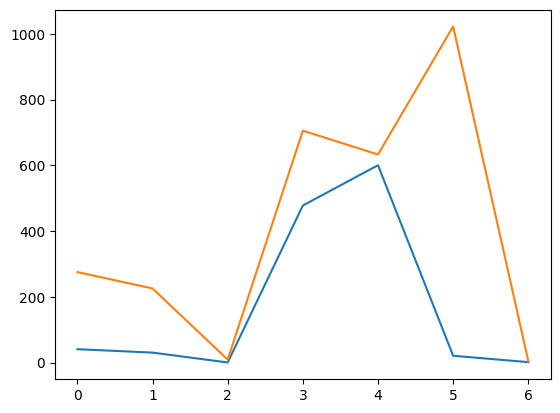

In [101]:
plt.plot(homol_human_conn.mean(axis=0))
plt.plot(homol_marm_conn.mean(axis=0))


In [106]:
#compute the argmax for each voxel:
marm_lbl = np.argmax(homol_marm_conn,axis=1)
human_lbl = np.argmax(homol_human_conn,axis=1)

(array([1071.,    0.,    0.,    0.,    0.,  957., 1854.]),
 array([0.        , 0.57142857, 1.14285714, 1.71428571, 2.28571429,
        2.85714286, 3.42857143, 4.        ]),
 <BarContainer object of 7 artists>)

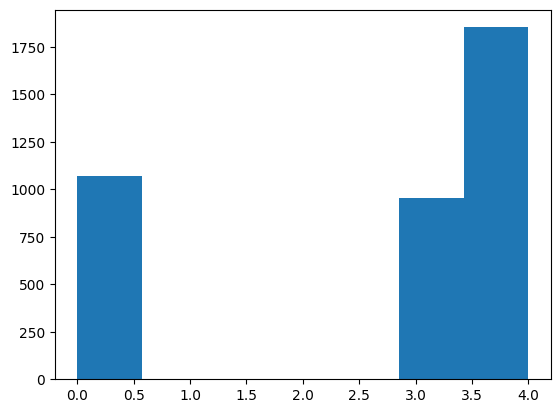

In [112]:
plt.hist(human_lbl,bins=7)

(array([ 66.,   6.,   0.,   0., 124., 186., 266.]),
 array([0.        , 0.71428571, 1.42857143, 2.14285714, 2.85714286,
        3.57142857, 4.28571429, 5.        ]),
 <BarContainer object of 7 artists>)

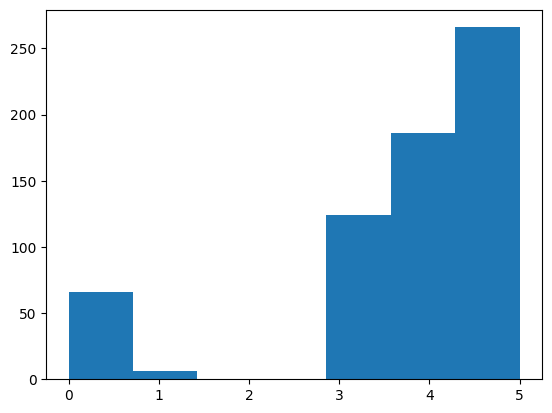

In [111]:
plt.hist(marm_lbl,bins=7)

In [138]:
#save marmoset zona labelling:
seed_L_file= '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/results/diffparc/sub-betty/sub-betty_hemi-L_space-individual_res-dwi_label-ZI_from-MBMv212_mask.nii.gz'

seed_header = nib.load(seed_L_file).header

seed_affine = data_L['affine']

lbl_vol = np.zeros(marm_mask_L.shape)
lbl_vol[marm_mask_L > 0]  = marm_lbl[:nvox_L]
lbl_vol[marm_mask_R > 0]  = marm_lbl[nvox_L:]

lbl_nib = nib.Nifti1Image(lbl_vol,seed_affine,header=seed_header)
lbl_nib.to_filename('marm_lbl.nii')

In [139]:
#save 4d conn map marm:

conn_vols = []
for i in range(homol_marm_conn.shape[1]):
    conn_vol = np.zeros(marm_mask_L.shape)
    conn_vol[marm_mask_L > 0] = homol_marm_conn[:marm_nvox_L,i]
    conn_vol[marm_mask_R > 0] = homol_marm_conn[marm_nvox_L:,i]
    conn_vols.append(conn_vol)

conn_4d = np.stack(conn_vols,axis=3)
conn_4d.shape

conn_nib = nib.Nifti1Image(conn_4d,seed_affine,header=seed_header)
conn_nib.to_filename('marm_conn_4d.nii')
                      

In [125]:
#save human zona labelling:
#seed_L_file = '/home/ROBARTS/alik/graham/scratch_tkai/3_projects/1_inprogress/zonaconn/zonaconn-smk_7T/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-L_label-ZIR_mask.nii.gz'
#seed_R_file = '/home/ROBARTS/alik/graham/scratch_tkai/3_projects/1_inprogress/zonaconn/zonaconn-smk_7T/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-R_label-ZIR_mask.nii.gz'

#seed_header = nib.load(seed_L_file).header
seed_affine = human_affine

lbl_vol = np.zeros(human_mask_L.shape)
lbl_vol[human_mask_L > 0]  = human_lbl[:human_nvox_L]
lbl_vol[human_mask_R > 0]  = human_lbl[human_nvox_L:]

lbl_nib = nib.Nifti1Image(lbl_vol,seed_affine)
lbl_nib.to_filename('human_lbl.nii')

In [133]:
#save 4d conn map human


conn_vols = []
for i in range(homol_human_conn.shape[1]):
    conn_vol = np.zeros(human_mask_L.shape)
    conn_vol[human_mask_L > 0] = homol_human_conn[:human_nvox_L,i]
    conn_vol[human_mask_R > 0] = homol_human_conn[human_nvox_L:,i]
    conn_vols.append(conn_vol)

conn_4d = np.stack(conn_vols,axis=3)
conn_4d.shape

conn_nib = nib.Nifti1Image(conn_4d,seed_affine)
conn_nib.to_filename('human_conn_4d.nii')
                                        
    


In [130]:
homol_human_conn.shape

(3882, 7)